In [1]:
#-- Import Required Python Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load Dataset
data = pd.read_csv('all_games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16300 entries, 0 to 16299
Data columns (total 24 columns):
period                  16300 non-null object
time                    16300 non-null object
seconds_left            16300 non-null float64
call_type               16299 non-null object
committing_player       15217 non-null object
disadvantaged_player    13506 non-null object
review_decision         15359 non-null object
comment                 16300 non-null object
video                   16288 non-null object
game_id                 16300 non-null object
play_id                 16300 non-null object
away                    16300 non-null object
home                    16300 non-null object
date                    16300 non-null int64
ref_1                   16264 non-null object
ref_2                   16264 non-null object
ref_3                   16264 non-null object
score_away              16264 non-null float64
score_home              16264 non-null float64
original_pdf   

In [3]:
# look at columns
data.columns

Index(['period', 'time', 'seconds_left', 'call_type', 'committing_player',
       'disadvantaged_player', 'review_decision', 'comment', 'video',
       'game_id', 'play_id', 'away', 'home', 'date', 'ref_1', 'ref_2', 'ref_3',
       'score_away', 'score_home', 'original_pdf', 'box_score_url',
       'disadvantaged_team', 'committing_team', 'ref_made_call'],
      dtype='object')

In [4]:
# Data cleaning
# replace team 'ARL' (misspell) as 'ATL'
data['disadvantaged_team'].replace('ARL','ATL',inplace=True)
# replace period 'Q3' (miswrote) as 'Q4'
data['period'].replace('Q3','Q4',inplace=True)

In [5]:
# First Plot: Favor Calls per Game by Team
# Calculate the games each team played in the data
UniqueTeam = data[['game_id','home','away']].drop_duplicates(subset=['game_id'])
TeamCount = pd.concat([UniqueTeam['home'].value_counts(),UniqueTeam['away'].value_counts()],axis=1)
TeamCount.reset_index(inplace=True)
TeamCount['Games'] = TeamCount['home'] + TeamCount['away']
TeamCount.columns = ['Team', 'Home', 'Away', 'Games']
TeamCount.drop(['Home','Away'],axis=1,inplace=True)
#print(TeamCount)

In [6]:
FavorTeam = data[['review_decision','disadvantaged_team', 'committing_team']]

In [7]:
# rows with incorrect non-calls and incorrect calls
idx_inc = FavorTeam['review_decision']=='INC'
idx_ic = FavorTeam['review_decision']=='IC'
# count each category (Favor team: INC-C and IC-D; Unfavor team: INC-D and IC-C) for every team
FT1 = FavorTeam.loc[idx_inc,['committing_team','disadvantaged_team']].groupby(['committing_team']).agg({'committing_team': 'count'})
FT1.columns=['INC-C']
FT2 = FavorTeam.loc[idx_ic,['disadvantaged_team']].groupby(['disadvantaged_team']).agg({'disadvantaged_team': 'count'})
FT2.columns=['IC-D']
UFT1 = FavorTeam.loc[idx_ic,['committing_team']].groupby(['committing_team']).agg({'committing_team': 'count'})
UFT1.columns=['IC-C']
UFT2 = FavorTeam.loc[idx_inc,['disadvantaged_team']].groupby(['disadvantaged_team']).agg({'disadvantaged_team': 'count'})
UFT2.columns=['INC-D']
FT = pd.concat([FT1,FT2,UFT1,UFT2], axis=1).reset_index()
FT['FC'] = FT['INC-C'] + FT['IC-D']
FT['UFC'] = FT['INC-D'] + FT['IC-C']
FT.drop(['INC-C','IC-D','INC-D','IC-C'],axis=1,inplace=True)
FT.columns = ['Team', 'FC', 'UFC']
# merge with games count
FT = pd.merge(FT, TeamCount, on='Team')
FT['UFC'] = -FT['UFC']
FT['Diff'] = FT['FC'] + FT['UFC']
FT['FC/G'] = FT['FC'] / FT['Games']
FT['UFC/G'] = FT['UFC'] / FT['Games']
FT['Diff/G'] = FT['Diff'] / FT['Games']
#print(FT)
print(FT[['Team','FC/G','UFC/G','Diff/G']].sort_values('Diff/G'))

   Team      FC/G     UFC/G    Diff/G
5   CLE  0.730159 -1.047619 -0.317460
28  UTA  0.637681 -0.942029 -0.304348
22  PHI  0.593220 -0.830508 -0.237288
13  LAL  0.500000 -0.711538 -0.211538
18  NOP  0.691176 -0.882353 -0.191176
3   CHA  0.645161 -0.790323 -0.145161
2   BOS  0.657534 -0.753425 -0.095890
23  PHO  0.767857 -0.857143 -0.089286
24  POR  0.657534 -0.739726 -0.082192
16  MIL  0.661538 -0.738462 -0.076923
6   DAL  0.970149 -1.044776 -0.074627
4   CHI  0.733333 -0.800000 -0.066667
9   GSW  0.854545 -0.909091 -0.054545
20  OKC  0.743243 -0.729730  0.013514
14  MEM  0.810811 -0.797297  0.013514
19  NYK  1.016393 -0.983607  0.032787
27  TOR  0.850000 -0.812500  0.037500
29  WAS  0.862500 -0.825000  0.037500
10  HOU  0.961538 -0.923077  0.038462
0   ATL  0.815789 -0.776316  0.039474
12  LAC  0.781250 -0.718750  0.062500
21  ORL  0.645161 -0.580645  0.064516
26  SAS  0.741935 -0.645161  0.096774
11  IND  0.833333 -0.722222  0.111111
1   BKN  0.783333 -0.666667  0.116667
25  SAC  0.7

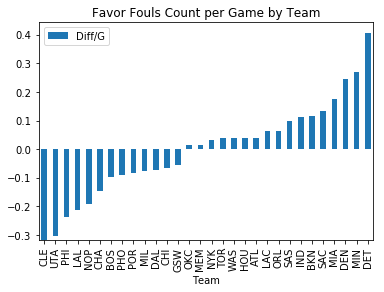

In [8]:
# Plot
plt.figure();
FT.sort_values('Diff/G').plot(x='Team', y=['Diff/G'], kind='bar', title='Favor Fouls Count per Game by Team')
plt.show()
#plt.savefig('FirstPlot.pdf')

In [9]:
# try to find any difference between calls in Q4 and overtime(Q5, Q6, Q7, Q8...), but failed, no significant difference
idx_Q4 = data['period']=='Q4'
dataQ4 = data[['period','review_decision']].loc[idx_Q4]
dataQQ = data[['period','review_decision']].loc[~idx_Q4]
print(dataQ4['review_decision'].value_counts()/dataQ4['review_decision'].count())
print(dataQQ['review_decision'].value_counts()/dataQQ['review_decision'].count())
#print(sum(idx_Q4)/data['period'].count())

CNC    0.562475
CC     0.333820
INC    0.092840
IC     0.010865
Name: review_decision, dtype: float64
CNC    0.511897
CC     0.381692
INC    0.092531
IC     0.013880
Name: review_decision, dtype: float64


In [10]:
# Second Plot: Types of Foul Calls that Favor the Win Team
# Construct a new column called the winning team
data['win'] = data['home']
idxhomewin = data['score_home'] > data['score_away']
data.loc[~idxhomewin,'win'] = data.loc[~idxhomewin,'away']
data.head()

,period,time,seconds_left,call_type,committing_player,disadvantaged_player,review_decision,comment,video,game_id,...,ref_2,ref_3,score_away,score_home,original_pdf,box_score_url,disadvantaged_team,committing_team,ref_made_call,win
0,Q4,0:01:52,112.0,Foul: Shooting,Josh Smith,Kevin Love,CNC,Smith (HOU) does not make contact with Love (C...,http://official.nba.com/last-two-minute-report...,20150301CLEHOU,...,Dan Crawford,Michael Smith,103.0,105.0,L2M-CLE-HOU-3-1-15.pdf,http://www.basketball-reference.com/boxscores/...,CLE,HOU,NaN,HOU
1,Q4,0:01:43,103.0,Foul: Shooting,J.R. Smith,James Harden,CC,Smith (CLE) makes contact with the body of Har...,http://official.nba.com/last-two-minute-report...,20150301CLEHOU,...,Dan Crawford,Michael Smith,103.0,105.0,L2M-CLE-HOU-3-1-15.pdf,http://www.basketball-reference.com/boxscores/...,HOU,CLE,NaN,HOU
2,Q4,0:01:32,92.0,Foul: Shooting,Trevor Ariza,LeBron James,CC,Ariza (HOU) makes contact with the shoulder of...,http://official.nba.com/last-two-minute-report...,20150301CLEHOU,...,Dan Crawford,Michael Smith,103.0,105.0,L2M-CLE-HOU-3-1-15.pdf,http://www.basketball-reference.com/boxscores/...,CLE,HOU,NaN,HOU
3,Q4,0:01:09,69.0,Foul: Loose Ball,Terrence Jones,Tristan Thompson,CC,Jones (HOU) makes contact with the arm of Thom...,http://official.nba.com/last-two-minute-report...,20150301CLEHOU,...,Dan Crawford,Michael Smith,103.0,105.0,L2M-CLE-HOU-3-1-15.pdf,http://www.basketball-reference.com/boxscores/...,CLE,HOU,NaN,HOU
4,Q4,0:00:53,53.0,Foul: Shooting,Tristan Thompson,Josh Smith,CNC,Smith (HOU) loses the ball as he goes up for t...,http://official.nba.com/last-two-minute-report...,20150301CLEHOU,...,Dan Crawford,Michael Smith,103.0,105.0,L2M-CLE-HOU-3-1-15.pdf,http://www.basketball-reference.com/boxscores/...,HOU,CLE,NaN,HOU


In [11]:
# Call impact data
callimpact = data[['call_type','review_decision','disadvantaged_team','committing_team','win']]
callimpact.head()

,call_type,review_decision,disadvantaged_team,committing_team,win
0,Foul: Shooting,CNC,CLE,HOU,HOU
1,Foul: Shooting,CC,HOU,CLE,HOU
2,Foul: Shooting,CC,CLE,HOU,HOU
3,Foul: Loose Ball,CC,CLE,HOU,HOU
4,Foul: Shooting,CNC,HOU,CLE,HOU


In [12]:
# indices for incorrect non-call, incorrect call, and all calls but correct non-call
index_inc = callimpact['review_decision'] == 'INC'
index_ic = callimpact['review_decision'] == 'IC'
index_call = callimpact['review_decision'] != 'CNC'
# compute total call counts (except CNC)
call_total_count = pd.DataFrame(callimpact['call_type'].loc[index_call].value_counts()).reset_index()
call_total_count.columns = ['call_type','call']

In [13]:
# rows with incorrect non-calls and incorrect calls
# and count each category (Favor win: INC-C and IC-D; Unfavor win: INC-D and IC-C) for every team
FW1_idx = (callimpact['review_decision'] == 'INC') & (callimpact['committing_team']==callimpact['win'])
FW1 = pd.DataFrame(callimpact['call_type'].loc[FW1_idx].value_counts())
FW2_idx = (callimpact['review_decision'] == 'IC') & (callimpact['disadvantaged_team']==callimpact['win'])
FW2 = pd.DataFrame(callimpact['call_type'].loc[FW2_idx].value_counts())
UFW1_idx = (callimpact['review_decision'] == 'INC') & (callimpact['disadvantaged_team']==callimpact['win'])
UFW1 = pd.DataFrame(callimpact['call_type'].loc[UFW1_idx].value_counts())
UFW2_idx = (callimpact['review_decision'] == 'IC') & (callimpact['committing_team']==callimpact['win'])
UFW2 = pd.DataFrame(callimpact['call_type'].loc[FW2_idx].value_counts())
FW1.columns=['INC-C']
FW2.columns=['IC-D']
UFW1.columns=['INC-D']
UFW2.columns=['IC-C']
FW = pd.concat([FW1,FW2,UFW1,UFW2], axis=1).reset_index().fillna(0)
FW['FWC'] = FW['INC-C'] + FW['IC-D']
FW['UFWC'] = FW['INC-D'] + FW['IC-C']
FW.drop(['INC-C','IC-D','INC-D','IC-C'],axis=1,inplace=True)
FW.columns = ['call_type', 'FWC', 'UFWC']
# merge with total call count
FW = pd.merge(FW, call_total_count, on='call_type')
FW['UFWC'] = -FW['UFWC']
FW['Diff'] = FW['FWC'] + FW['UFWC']
# filter out small foul calls (<=10)
valid_idx = FW['call']>10
FW.loc[valid_idx,['call_type','FWC','UFWC','Diff']].sort_values('Diff')

,call_type,FWC,UFWC,Diff
6,Foul: Offensive,109.0,-180.0,-71.0
7,Foul: Personal,120.0,-152.0,-32.0
1,Foul: Defense 3 Second,48.0,-71.0,-23.0
29,Turnover: Traveling,95.0,-115.0,-20.0
0,Foul: Away from Play,5.0,-10.0,-5.0
31,Violation: Delay of Game,0.0,-5.0,-5.0
25,Turnover: Out of Bounds,1.0,-5.0,-4.0
16,Turnover: 5 Second Inbound,5.0,-9.0,-4.0
35,Violation: Lane,7.0,-11.0,-4.0
24,Turnover: Offensive Goaltending,0.0,-2.0,-2.0


In [15]:
# plot
plt.figure();
FW.loc[valid_idx,['call_type','FWC','UFWC','Diff']].sort_values('Diff').plot(x='call_type', y=['Diff'], kind='barh', title='Favor Fouls Count per Game by Call')
plt.show()
#plt.savefig('SecondPlot.pdf')